In [1]:
import mediapy as media

import glider.visualize as visualize

# GliderSIM

This is a genetic algorithm to optimise a glider form.

That means we put a population of gliders through a test and see which perform the best.

The best gliders of that generation have offspring and so we improve the performance over time.


## The Gliders

Gliders are a combination of points and faces that make up a polygon. They look like this:

""

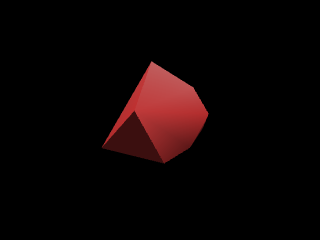

In [2]:
from glider.vehicle import Vehicle

v = Vehicle(num_vertices=10)

media.show_image(visualize.view_vehicle(v))

## The Test

The test is a drop from 80m.

The glider's score is determined by the distance travelled to the left or right.

In [3]:
import glider.simulation as simulation

test_xml_representation = simulation.drop_test_glider(v)

visualize.render_xml_to_collision(
    test_xml_representation,
    camera_name="fixed",
    show=True
)

The `fitness_func` renders this simulation, and returns the total distance travelled in the x-direction.

In [4]:
import glider.optimization as optimization

score = optimization.fitness_func(v)

print(f"Glider Score: {score}")

Glider Score: 6.452050391789485


## Getting better gliders

The simplest way to get a better glider, is to try many random gliders. 

In the cell below, we create and test a population of 100 gliders.

In [5]:
population = [Vehicle(num_vertices=10) for _ in range(100)]

fitnesses = [optimization.fitness_func(v) for v in population]

This is what the top performers looked like:

""

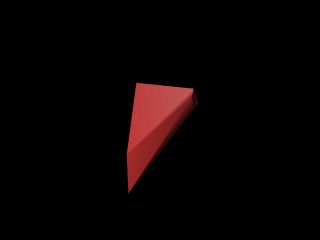

Fitness: 17.451700185761183


""

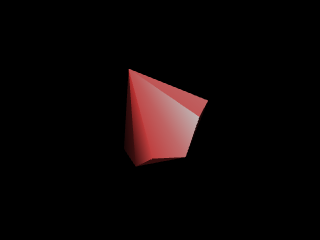

Fitness: 17.429975620277833


""

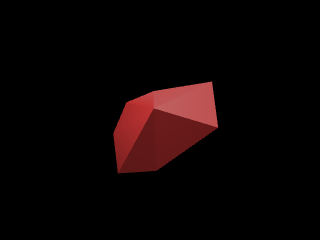

Fitness: 16.93555619501516


In [6]:
ranking = list(zip(population, fitnesses))
ranking.sort(key=lambda x: x[1], reverse=True)  # Sort by highest to lowest fitness

for glider, fitness in ranking[:3]:
    media.show_image(visualize.view_vehicle(glider))
    print(f"Fitness: {fitness}")

Graphing the distribution of the glider performances, we get:

<Axes: ylabel='Frequency'>

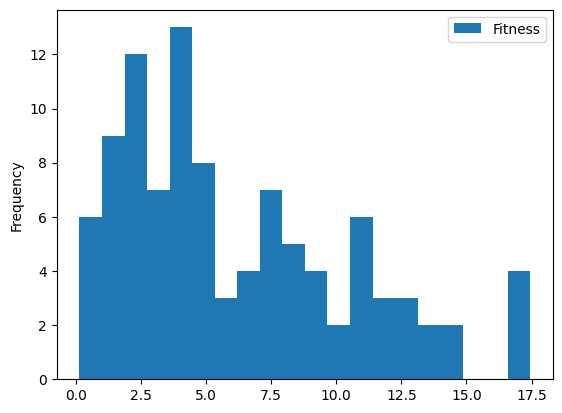

In [7]:
import pandas as pd
import matplotlib.pyplot as plt

df = pd.DataFrame(ranking, columns=["Vehicle", "Fitness"])
df.plot.hist(bins=20)

And the drop test for the best glider, looked like this:

In [8]:
winning_glider, fitness = ranking[0]

drop_test_xml = simulation.drop_test_glider(winning_glider)

visualize.render_xml_to_collision(
    drop_test_xml,
    camera_name="fixed",
    show=True
)

In [9]:
import time
from io import BytesIO

import numpy as np
from PIL import Image

from glider.optimization import iterate_population, fitness_func, NUM_GENES
from glider.vehicle import VehicleConfig

NUM_GENERATIONS = 300
POPULATION_SIZE = 100

t0 = time.perf_counter()
input_population = [Vehicle(num_vertices=NUM_GENES) for _ in range(POPULATION_SIZE)]

best_glider_frames = []
population_performance_frames = []
for i in range(NUM_GENERATIONS):
    # Take an input population, and select vehicles to survive based on 
    # survival_weight and cloning_weight

    # Create a new generation by cloning and mutating the surviving vehicles
    # to achieve the same population size


    input_ranking, new_population = iterate_population(
        input_population=input_population,
        survival_weight = 0.1,
        cloning_weight = 0.1,
    )

    if i % 10 == 0:
        print("Iteration:", i)

        winning_vehicle = input_ranking[0][0]
        print("Fitness:", fitness_func(winning_vehicle))
    
    best_glider_frames.append(visualize.view_vehicle(winning_vehicle))
    population_performance_frames.append(visualize.graph_population(input_ranking))

    input_population = new_population

t1 = time.perf_counter()
ga_time = t1 - t0

print(f"Time taken: {ga_time:.2f} seconds")

Iteration: 0
Fitness: 23.284902257362642
Iteration: 10
Fitness: 29.568938479014104
Iteration: 20
Fitness: 47.569661855117424
Iteration: 30
Fitness: 56.16856035183524
Iteration: 40
Fitness: 56.16856035183524
Iteration: 50
Fitness: 56.16856035183524
Iteration: 60
Fitness: 56.16856035183524
Iteration: 70
Fitness: 56.75259594488787
Iteration: 80
Fitness: 56.75259594488787
Iteration: 90
Fitness: 56.75259594488787
Iteration: 100
Fitness: 56.75259594488787
Iteration: 110
Fitness: 56.75259594488787
Iteration: 120
Fitness: 56.75259594488787
Iteration: 130
Fitness: 56.75259594488787
Iteration: 140
Fitness: 56.75259594488787
Iteration: 150
Fitness: 56.75259594488787
Iteration: 160
Fitness: 56.75259594488787
Iteration: 170
Fitness: 56.75259594488787
Iteration: 180
Fitness: 56.75259594488787
Iteration: 190
Fitness: 56.75259594488787
Iteration: 200
Fitness: 56.75259594488787
Iteration: 210
Fitness: 56.75259594488787
Iteration: 220
Fitness: 56.75259594488787
Iteration: 230
Fitness: 56.75259594488787


In [10]:
media.show_video(population_performance_frames, fps=10)

In [11]:
media.show_video(best_glider_frames, fps=3)
best_glider_frames[0].shape

(240, 320, 3)

In [12]:
from glider.optimization import evaluate_population
# Test the best glider of a 300 * 100 population

t2 = time.perf_counter()

mega_population = [Vehicle(num_vertices=NUM_GENES) for _ in range(NUM_GENERATIONS * POPULATION_SIZE)]
ranking = evaluate_population(mega_population)

best_random_glider, fitness = ranking[0]

t3 = time.perf_counter()
brute_force_time = t3 - t2

print("Best fitness from mega_population:", fitness)
print("Best fitness from genetic algorithm:", fitness_func(winning_vehicle))


Best fitness from mega_population: 30.451245904823466
Best fitness from genetic algorithm: 59.466741852110516


In [16]:
ga_time = 8*60 + 41
brute_force_time = 6*60 + 40

print("Percentage improvement:", (fitness_func(winning_vehicle) - fitness) / fitness * 100)

print(f"Time taken: {brute_force_time:.2f} seconds")

ga_improvement_per_second = fitness_func(winning_vehicle) / ga_time
brute_force_improvement_per_second = fitness / brute_force_time

print("Genetic algorithm improvement per second:", ga_improvement_per_second)
print("Brute force improvement per second:", brute_force_improvement_per_second)

time_efficiency_gain = ga_improvement_per_second / brute_force_improvement_per_second * 100
print("Time Efficiency Gain:", time_efficiency_gain)

Percentage improvement: 95.28508632446795
Time taken: 400.00 seconds
Genetic algorithm improvement per second: 0.11413961967775531
Brute force improvement per second: 0.07612811476205866


In [13]:
import glider.simulation as sim

test_xml_representation = simulation.drop_test_glider(winning_vehicle)

visualize.render_xml_to_collision(
    test_xml_representation,
    camera_name="fixed",
    show=True
)

In [14]:
print(test_xml_representation)


<mujoco>
    <option density="1.2" viscosity="2e-05" wind="0 0 0"/>
    <worldbody>
        <light name="top" pos="0 0 5"/>
        <camera name="fixed" pos="0 -100 100" euler="40 0 0"/>
        <!-- Body -->
        
    <body name="body" pos="0 0 0" euler="0.0 0.0 0.0">
        <freejoint/>
        <!-- Main Wing -->
        <geom name="vehicle-wing" density="0.4" pos="-3.0 -3.0 -3.0" rgba="0.8 0.2 0.2 0.5" type="mesh" mesh="vehicle-wing-mesh"/>
        <camera name="track" pos="0 0 0" xyaxes="1 2 0 0 1 2" mode="track"/>
        
    </body>
    
        <!-- Landing Platform -->
        <body name="platform" pos="0 0 0">
            <geom name="platform-geom" type="box" size="1500 1500 1" rgba="1 1 1 1" pos="0 0 -80"/>
        </body>
    </worldbody>

    
            <asset>
                <mesh name="vehicle-wing-mesh" vertex="0.9247984686439482 3.3802486767528612 1.1859977960924855 3.3372759961894674 1.3400629431566977 1.762699957254552 2.3933026457742517 1.6424216264633036 1.